In [18]:
# -----------------------------
# 1. LIBRARY IMPORTS
# -----------------------------
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# -----------------------------
# 2. PATHS AND CONSTANTS
# -----------------------------
train_dir = r"C:\Users\User\Documents\Neural Network Assignment 6\catvdog\train"
test_dir  = r"C:\Users\User\Documents\Neural Network Assignment 6\catvdog\test"

IMG_SIZE = (224, 224)  # ResNet standard input size
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 15

In [20]:
# -----------------------------
# 3. DATA PREPROCESSING & AUGMENTATION
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 16000 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [21]:
# -----------------------------
# 4. RESNET50 MODEL
# -----------------------------
base_model = ResNet50(
    weights='imagenet',        
    include_top=False,          # Remove top layer
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the base model initially
base_model.trainable = False

# Custom top layers
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Compile model (initial training)
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,153,473 (92.14 MB)

 Trainable params: 561,665 (2.14 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [22]:
# -----------------------------
# 5. CALLBACKS
# -----------------------------
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_resnet50.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)


In [23]:
# -----------------------------
# 6. TRAIN MODEL (HEAD ONLY)
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/15
121/500 ━━━━━━━━━━━━━━━━━━━━ 7:06 1s/step - accuracy: 0.7398 - auc: 0.8102 - loss: 1.2016 - precision: 0.7598 - recall: 0.6786

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8620 - auc: 0.9277 - loss: 1.0013 - precision: 0.8722 - recall: 0.8405
Epoch 1: val_auc improved from None to 0.99782, saving model to best_resnet50.h5

Epoch 1: val_auc improved from None to 0.99782, saving model to best_resnet50.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 1232s 2s/step - accuracy: 0.9249 - auc: 0.9787 - loss: 0.8934 - precision: 0.9296 - recall: 0.9194 - val_accuracy: 0.9805 - val_auc: 0.9978 - val_loss: 0.7661 - val_precision: 0.9824 - val_recall: 0.9785 - learning_rate: 1.0000e-04
Epoch 2/15
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9642 - auc: 0.9930 - loss: 0.7999 - precision: 0.9614 - recall: 0.9671
Epoch 2: val_auc improved from 0.99782 to 0.99878, saving model to best_resnet50.h5

Epoch 2: val_auc improved from 0.99782 to 0.99878, saving model to best_resnet50.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - accuracy: 0.9642 - auc: 0.9930 - loss: 0.7886 - precision: 0.9626 - recall: 0.9659 - val_accuracy: 0.9847 - val_auc: 0.9988 - val_loss: 0.7176 - val_precision: 0.9879 - val_recall: 0.9815 - learning_rate: 1.0000e-04
Epoch 3/15
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9709 - auc: 0.9951 - loss: 0.7457 - precision: 0.9714 - recall: 0.9700
Epoch 3: val_auc did not improve from 0.99878
500/500 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step - accuracy: 0.9712 - auc: 0.9952 - loss: 0.7336 - precision: 0.9718 - recall: 0.9705 - val_accuracy: 0.9842 - val_auc: 0.9987 - val_loss: 0.6741 - val_precision: 0.9840 - val_recall: 0.9845 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 3: val_auc did not improve from 0.99878
500/500 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step - accuracy: 0.9712 - auc: 0.9952 - loss: 0.7336 - precision: 0.9718 - recall: 0.9705 - val_accuracy: 0.9842 - val_auc: 0.9987 - val_loss: 0.6741 - val_precision: 0.9840 - val_recall: 0.98

500/500 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - accuracy: 0.9766 - auc: 0.9966 - loss: 0.5940 - precision: 0.9782 - recall: 0.9750 - val_accuracy: 0.9857 - val_auc: 0.9990 - val_loss: 0.5519 - val_precision: 0.9831 - val_recall: 0.9885 - learning_rate: 1.0000e-04
Epoch 7/15
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9802 - auc: 0.9975 - loss: 0.5565 - precision: 0.9796 - recall: 0.9809
Epoch 7: val_auc did not improve from 0.99903
500/500 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.9801 - auc: 0.9977 - loss: 0.5464 - precision: 0.9790 - recall: 0.9811 - val_accuracy: 0.9875 - val_auc: 0.9988 - val_loss: 0.5115 - val_precision: 0.9899 - val_recall: 0.9850 - learning_rate: 1.0000e-04
Epoch 8/15

Epoch 7: val_auc did not improve from 0.99903
500/500 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.9801 - auc: 0.9977 - loss: 0.5464 - precision: 0.9790 - recall: 0.9811 - val_accuracy: 0.9875 - val_auc: 0.9988 - val_loss: 0.5115 - val_precision: 0.9899 - val_recall: 0.98

In [24]:
# -----------------------------
# 7. FINE-TUNE LAST LAYERS
# -----------------------------
# Unfreeze a subset of the base model for fine-tuning
base_model.trainable = True

# Keep BatchNorm layers frozen for stability
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Optionally unfreeze only the last ~50 layers
if len(base_model.layers) > 50:
    for layer in base_model.layers[:-50]:
        layer.trainable = False

# Re-compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=max(5, EPOCHS // 2),
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9814 - auc: 0.9975 - loss: 0.5618 - precision: 0.9813 - recall: 0.9821
Epoch 1: val_auc did not improve from 0.99903
500/500 ━━━━━━━━━━━━━━━━━━━━ 1072s 2s/step - accuracy: 0.9816 - auc: 0.9975 - loss: 0.5599 - precision: 0.9811 - recall: 0.9820 - val_accuracy: 0.9855 - val_auc: 0.9983 - val_loss: 0.5444 - val_precision: 0.9826 - val_recall: 0.9885 - learning_rate: 1.0000e-05
Epoch 2/7

Epoch 1: val_auc did not improve from 0.99903
500/500 ━━━━━━━━━━━━━━━━━━━━ 1072s 2s/step - accuracy: 0.9816 - auc: 0.9975 - loss: 0.5599 - precision: 0.9811 - recall: 0.9820 - val_accuracy: 0.9855 - val_auc: 0.9983 - val_loss: 0.5444 - val_precision: 0.9826 - val_recall: 0.9885 - learning_rate: 1.0000e-05
Epoch 2/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9883 - auc: 0.9985 - loss: 0.5435 - precision: 0.9881 - recall: 0.9884
Epoch 2: val_auc did not improve from 0.99903
500/500 ━━━━━━━━━━━━━━━━━━━━ 972s 2s/step - accuracy: 0.987

In [25]:
# EVALUATE THE MODEL
results = model.evaluate(test_generator, return_dict=True)
print(f"Test Accuracy: {results.get('accuracy', float('nan')):.4f}")
print(f"Test AUC: {results.get('auc', float('nan')):.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9884 - auc: 0.9993 - loss: 0.5347 - precision: 0.9838 - recall: 0.9932
157/157 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9884 - auc: 0.9993 - loss: 0.5347 - precision: 0.9838 - recall: 0.9932
Test Accuracy: 0.9884
Test AUC: 0.9993
Test Accuracy: 0.9884
Test AUC: 0.9993


In [26]:
# SAVE THE MODEL
model.save('exercise_6_resnetcatvsdog_palabrica.h5')

In [30]:
# SIMPLE INFERENCE SCRIPT FOR CATS VS DOGS
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

# Full path to your trained model
MODEL_PATH = r"C:\Users\User\Downloads\FINAL\Files\exercise_6_resnetcatvsdog_palabrica.h5"

# Load the model once
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found at: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

# Derive required input size from the model to avoid mismatches
_input_shape = model.input_shape
if isinstance(_input_shape, list):
    _input_shape = _input_shape[0]
if (
    _input_shape is None
    or len(_input_shape) < 4
    or _input_shape[1] is None
    or _input_shape[2] is None
):
    IMG_SIZE = (128, 128)  # fallback if model doesn't specify
else:
    IMG_SIZE = (int(_input_shape[1]), int(_input_shape[2]))

# Optional: quick confirmation
print(f"Model expects input size: {IMG_SIZE}")

# Use the same preprocessing as training (ResNet50)
from tensorflow.keras.applications.resnet50 import preprocess_input

def _preprocess(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    return arr

def predict_image(img_path):
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return

    # Load image for display
    pil_img = image.load_img(img_path, target_size=IMG_SIZE)

    # Make prediction using same preprocessing as training
    batch = _preprocess(img_path)
    pred = float(model.predict(batch, verbose=0)[0, 0])  # single value for binary classification

    # Convert prediction to label + confidence (probability of predicted class)
    if pred >= 0.5:
        label = "Dog"
        confidence = pred
        title_color = 'tab:green'
    else:
        label = "Cat"
        confidence = 1.0 - pred
        title_color = 'tab:blue'

    # Show image with title
    plt.figure(figsize=(4, 4))
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title(f"{label} (confidence: {confidence:.2f})", color=title_color)
    plt.show()


Model expects input size: (224, 224)


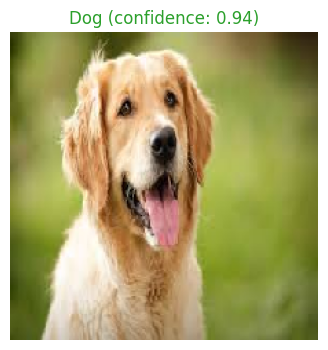

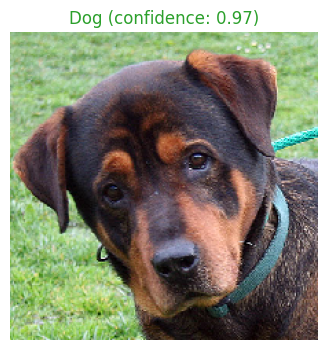

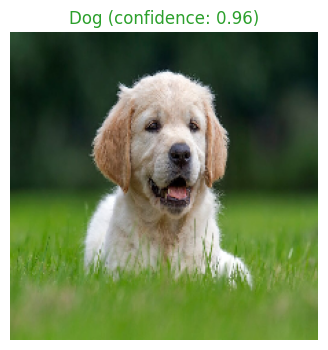

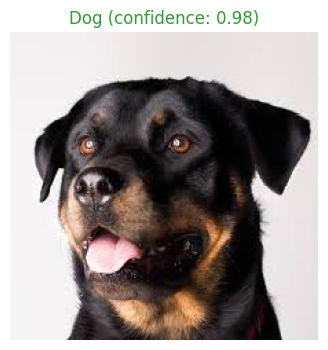

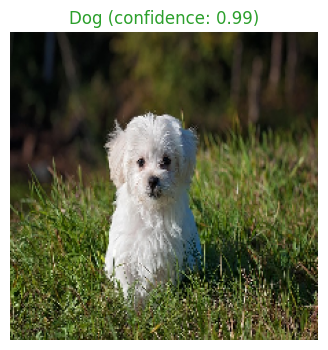

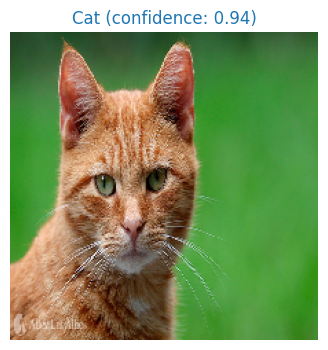

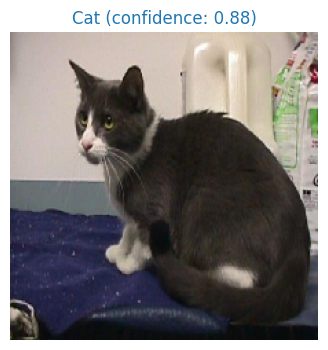

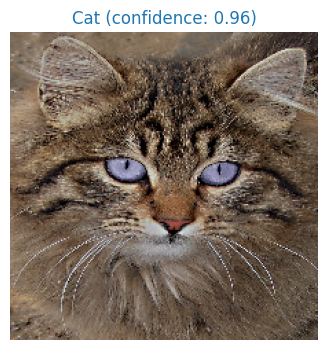

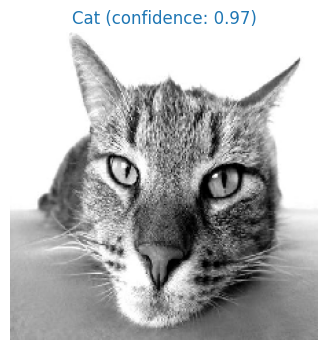

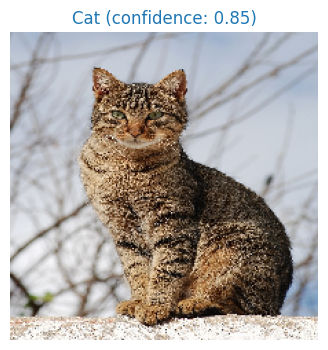

In [33]:

predict_image(r"C:\Users\User\Documents\dog.jpg")
predict_image(r"C:\Users\User\Documents\dog1.jpg")
predict_image(r"C:\Users\User\Documents\dog2.jpg")
predict_image(r"C:\Users\User\Documents\dog3.jpg")
predict_image(r"C:\Users\User\Documents\dog4.jpg")
predict_image(r"C:\Users\User\Documents\cat.jpg")
predict_image(r"C:\Users\User\Documents\cat1.jpg")
predict_image(r"C:\Users\User\Documents\cat2.jpg")
predict_image(r"C:\Users\User\Documents\cat3.jpg")
predict_image(r"C:\Users\User\Documents\cat4.jpg")

